# Script description

Here will be script that are the axample of using simple autoencoders:
1. Basic autoencoder for reconstruction
2. Image denoising
3. Convolutional ae
4. Anomaly detection

## Define functions

In [22]:
def plot_results(original_ds, decoded_ds, num_ims=10):

    plt.figure(figsize=(20, 4))

    for i in range(num_ims):
        # display original
        ax = plt.subplot(2, num_ims, i + 1)
        plt.imshow(original_ds[i])
        plt.title("original")
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(2, num_ims, i + 1 + num_ims)
        plt.imshow(decoded_ds[i])
        plt.title("reconstructed")
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()
    return

In [25]:
def plot_ds_examples(dataset, num_ims=10):
    
    plt.figure(figsize=(20, 2))
    
    for i in range(num_ims):
        ax = plt.subplot(1, num_ims, i + 1)
        plt.title("original + noise")
        plt.imshow(tf.squeeze(dataset[i]))
        plt.gray()
    plt.show()
    return

## Import libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os, sys

import tensorflow as tf
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import fashion_mnist

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split

## Set parameters

In [2]:
latent_dim = 64
epoch = 10
noise_factor = 0.2

## Load the dataset

In [15]:
(x_train, _), (x_test, _) = fashion_mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

print (x_train.shape)
print (x_test.shape)

(60000, 28, 28)
(10000, 28, 28)


## Example 1: Basic autoencoder

In [5]:
class Autoencoder(Model):
    def __init__(self, latent_dim):
        super(Autoencoder, self).__init__()
        self.latent_dim = latent_dim   
        self.encoder = tf.keras.Sequential([
          layers.Flatten(),
          layers.Dense(latent_dim, activation='relu'),
        ])
        self.decoder = tf.keras.Sequential([
          layers.Dense(784, activation='sigmoid'),
          layers.Reshape((28, 28))
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

basic_ae = Autoencoder(latent_dim)

In [6]:
basic_ae.compile(optimizer='adam', loss=losses.MeanSquaredError())
basic_ae.fit(
    x_train, x_train,
    epochs=epoch,
    shuffle=True,
    validation_data=(x_test, x_test))

Epoch 1/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.0235 - val_loss: 0.0134
Epoch 2/10
1875/1875 [==============================] - 2s 996us/step - loss: 0.0116 - val_loss: 0.0106
Epoch 3/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.0101 - val_loss: 0.0097
Epoch 4/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.0095 - val_loss: 0.0094
Epoch 5/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.0092 - val_loss: 0.0093
Epoch 6/10
1875/1875 [==============================] - 2s 987us/step - loss: 0.0090 - val_loss: 0.0090
Epoch 7/10
1875/1875 [==============================] - 2s 987us/step - loss: 0.0089 - val_loss: 0.0090
Epoch 8/10
1875/1875 [==============================] - 2s 982us/step - loss: 0.0089 - val_loss: 0.0090
Epoch 9/10
1875/1875 [==============================] - 2s 997us/step - loss: 0.0088 - val_loss: 0.0089
Epoch 10/10
1875/1875 [==============================] - 2s 1ms/step - l

In [8]:
encoded_imgs = basic_ae.encoder(x_test).numpy()
decoded_imgs = basic_ae.decoder(encoded_imgs).numpy()

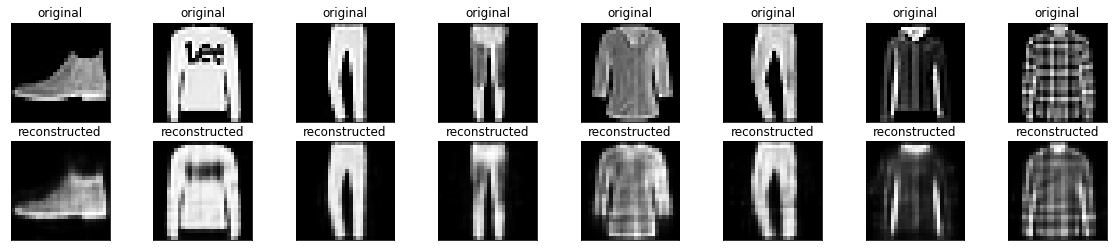

In [11]:
plot_results(x_test, decoded_imgs, 8)

## Example 2: Image denoising

In [16]:
x_train = x_train[..., tf.newaxis]
x_test = x_test[..., tf.newaxis]
print(x_train.shape)

(60000, 28, 28, 1)


In [17]:
x_train_noisy = x_train + noise_factor * tf.random.normal(shape=x_train.shape) 
x_test_noisy = x_test + noise_factor * tf.random.normal(shape=x_test.shape) 

x_train_noisy = tf.clip_by_value(x_train_noisy, clip_value_min=0., clip_value_max=1.)
x_test_noisy = tf.clip_by_value(x_test_noisy, clip_value_min=0., clip_value_max=1.)

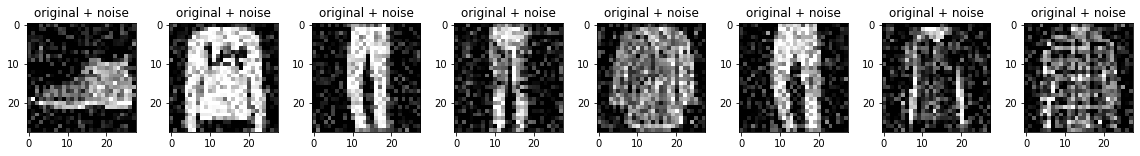

In [24]:
plot_ds_examples(x_test_noisy, 8)

### define convolutional autoencoder

In [26]:
class Denoise(Model):
    def __init__(self):
        super(Denoise, self).__init__()
        self.encoder = tf.keras.Sequential([
          layers.Input(shape=(28, 28, 1)),
          layers.Conv2D(16, (3, 3), activation='relu', padding='same', strides=2),
          layers.Conv2D(8, (3, 3), activation='relu', padding='same', strides=2)])

        self.decoder = tf.keras.Sequential([
          layers.Conv2DTranspose(8, kernel_size=3, strides=2, activation='relu', padding='same'),
          layers.Conv2DTranspose(16, kernel_size=3, strides=2, activation='relu', padding='same'),
          layers.Conv2D(1, kernel_size=(3, 3), activation='sigmoid', padding='same')])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

denoise_ae = Denoise()

In [27]:
denoise_ae.compile(optimizer='adam', loss=losses.MeanSquaredError())
denoise_ae.fit(
    x_train_noisy, x_train,
    epochs=epoch,
    shuffle=True,
    validation_data=(x_test_noisy, x_test))

Epoch 1/10
1875/1875 [==============================] - 22s 11ms/step - loss: 0.0189 - val_loss: 0.0120
Epoch 2/10
1875/1875 [==============================] - 21s 11ms/step - loss: 0.0109 - val_loss: 0.0101
Epoch 3/10
1875/1875 [==============================] - 21s 11ms/step - loss: 0.0098 - val_loss: 0.0097
Epoch 4/10
1875/1875 [==============================] - 21s 11ms/step - loss: 0.0094 - val_loss: 0.0093
Epoch 5/10
1875/1875 [==============================] - 21s 11ms/step - loss: 0.0092 - val_loss: 0.0093
Epoch 6/10
1875/1875 [==============================] - 21s 11ms/step - loss: 0.0091 - val_loss: 0.0090
Epoch 7/10
1875/1875 [==============================] - 21s 11ms/step - loss: 0.0089 - val_loss: 0.0089
Epoch 8/10
1875/1875 [==============================] - 21s 11ms/step - loss: 0.0088 - val_loss: 0.0088
Epoch 9/10
1875/1875 [==============================] - 21s 11ms/step - loss: 0.0087 - val_loss: 0.0087
Epoch 10/10
1875/1875 [==============================] - 21s 11m

In [28]:
# denoise_ae.encoder.summary()
# denoise_ae.decoder.summary()

In [29]:
encoded_imgs = denoise_ae.encoder(x_test_noisy).numpy()
decoded_imgs = denoise_ae.decoder(encoded_imgs).numpy()

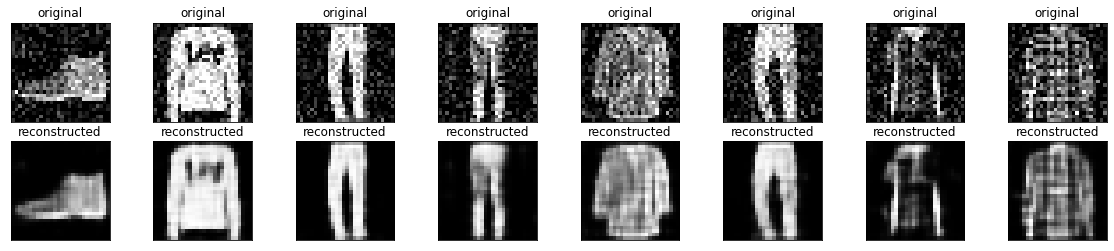

In [30]:
plot_results(x_test_noisy, decoded_imgs, 8)

## Example 3: Anomaly detection

### Load ECG data

In [3]:
# Download the dataset
dataframe = pd.read_csv('http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv', header=None)
raw_data = dataframe.values
dataframe.head()

,0,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,140
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818286,-1.250522,-0.477492,...,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1.0
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,...,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1.0
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490659,-1.183580,-0.394229,...,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1.0
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,...,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,1.0
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,...,1.148884,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456,1.0


In [4]:
# The last element contains the labels
labels = raw_data[:, -1]

# The other data points are the electrocadriogram data
data = raw_data[:, 0:-1]

train_data, test_data, train_labels, test_labels = train_test_split(
    data, labels, test_size=0.2, random_state=21)

In [5]:
# Normalize the data to [0,1]
min_val = tf.reduce_min(train_data)
max_val = tf.reduce_max(train_data)

train_data = (train_data - min_val) / (max_val - min_val)
test_data = (test_data - min_val) / (max_val - min_val)

train_data = tf.cast(train_data, tf.float32)
test_data = tf.cast(test_data, tf.float32)

In [6]:
train_labels = train_labels.astype(bool)
test_labels = test_labels.astype(bool)

normal_train_data = train_data[train_labels]
normal_test_data = test_data[test_labels]

anomalous_train_data = train_data[~train_labels]
anomalous_test_data = test_data[~test_labels]


In [7]:
np.shape(anomalous_test_data)

TensorShape([440, 140])

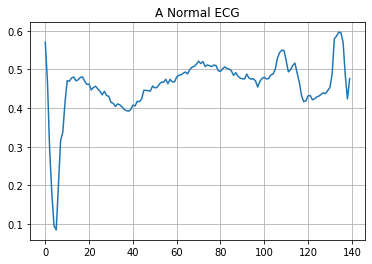

In [8]:
# Plot a normal ECG
plt.grid()
plt.plot(np.arange(140), normal_train_data[0])
plt.title("A Normal ECG")
plt.show()

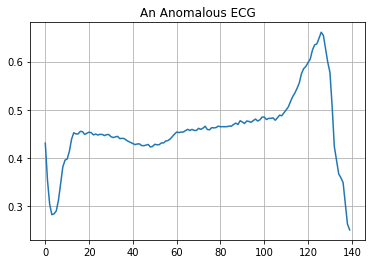

In [9]:
# Plot an anomalous ECG
plt.grid()
plt.plot(np.arange(140), anomalous_train_data[0])
plt.title("An Anomalous ECG")
plt.show()

### Build the model

In [10]:
class AnomalyDetector(Model):
    def __init__(self):
        super(AnomalyDetector, self).__init__()
        self.encoder = tf.keras.Sequential([
          layers.Dense(32, activation="relu"),
          layers.Dense(16, activation="relu"),
          layers.Dense(8, activation="relu")])

        self.decoder = tf.keras.Sequential([
          layers.Dense(16, activation="relu"),
          layers.Dense(32, activation="relu"),
          layers.Dense(140, activation="sigmoid")])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

anomal_ae = AnomalyDetector()

In [11]:
anomal_ae.compile(optimizer='adam', loss=losses.MeanSquaredError())
history = anomal_ae.fit(
    normal_train_data, normal_train_data,
    epochs=epoch*2,
    batch_size=512,
    shuffle=True,
    validation_data=(test_data, test_data))

Epoch 1/20
5/5 [==============================] - 0s 29ms/step - loss: 0.0069 - val_loss: 0.0069
Epoch 2/20
5/5 [==============================] - 0s 6ms/step - loss: 0.0067 - val_loss: 0.0067
Epoch 3/20
5/5 [==============================] - 0s 5ms/step - loss: 0.0065 - val_loss: 0.0065
Epoch 4/20
5/5 [==============================] - 0s 6ms/step - loss: 0.0061 - val_loss: 0.0063
Epoch 5/20
5/5 [==============================] - 0s 6ms/step - loss: 0.0056 - val_loss: 0.0060
Epoch 6/20
5/5 [==============================] - 0s 6ms/step - loss: 0.0050 - val_loss: 0.0057
Epoch 7/20
5/5 [==============================] - 0s 6ms/step - loss: 0.0044 - val_loss: 0.0055
Epoch 8/20
5/5 [==============================] - 0s 6ms/step - loss: 0.0038 - val_loss: 0.0052
Epoch 9/20
5/5 [==============================] - 0s 5ms/step - loss: 0.0033 - val_loss: 0.0048
Epoch 10/20
5/5 [==============================] - 0s 6ms/step - loss: 0.0028 - val_loss: 0.0044
Epoch 11/20
5/5 [=====================

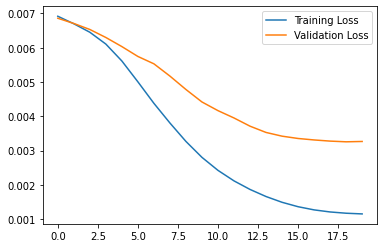

In [12]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

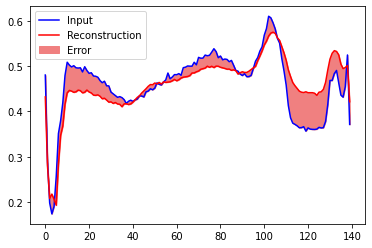

In [13]:
encoded_nomal_data = anomal_ae.encoder(normal_test_data).numpy()
decoded_nomal_data = anomal_ae.decoder(encoded_nomal_data).numpy()

plt.plot(normal_test_data[0], 'b')
plt.plot(decoded_nomal_data[0], 'r')
plt.fill_between(np.arange(140), decoded_nomal_data[0], normal_test_data[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

In [16]:
print(np.shape(anomalous_test_data))
print(np.shape(encoded_anomal_data))

(440, 140)
(440, 8)


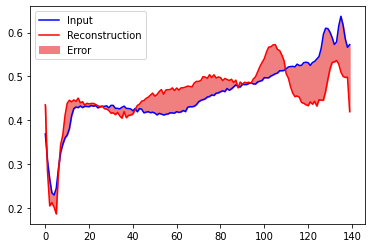

In [19]:
# Create a similar plot, this time for an anomalous test example
aencoded_data = anomal_ae.encoder(anomalous_test_data).numpy()
adecoded_data = anomal_ae.decoder(aencoded_data).numpy()

plt.plot(anomalous_test_data[0], 'b')
plt.plot(adecoded_data[0], 'r')
plt.fill_between(np.arange(140), adecoded_data[0], anomalous_test_data[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

### Detect anomalies

Detect anomalies by calculating whether the reconstruction loss is greater than a fixed threshold. 
Here will calculate the mean average error for normal examples from the training set, then classify future examples as anomalous if the reconstruction error is higher than one standard deviation from the training set.

74/74 [==============================] - 0s 466us/step


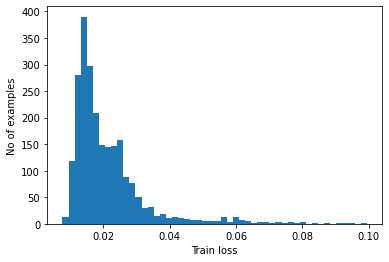

In [21]:
# Plot the reconstruction error on normal ECGs from the training set
reconstructions = anomal_ae.predict(normal_train_data)
train_loss = tf.keras.losses.mae(reconstructions, normal_train_data)

plt.hist(train_loss[None,:], bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

In [22]:
# Choose a threshold value that is one standard deviations above the mean
threshold = np.mean(train_loss) + np.std(train_loss)
print("Threshold: ", threshold)

Threshold:  0.032455675


14/14 [==============================] - 0s 616us/step


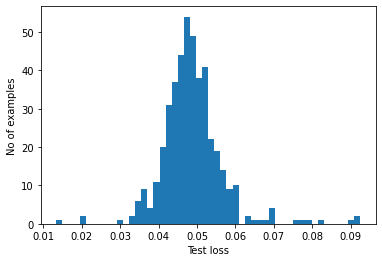

In [23]:
reconstructions = anomal_ae.predict(anomalous_test_data)
test_loss = tf.keras.losses.mae(reconstructions, anomalous_test_data)

plt.hist(test_loss[None, :], bins=50)
plt.xlabel("Test loss")
plt.ylabel("No of examples")
plt.show()

In [ ]:
# Classify an ECG as an anomaly if the reconstruction error is greater than the threshold

In [24]:
def predict(model, data, threshold):
    reconstructions = model(data)
    loss = tf.keras.losses.mae(reconstructions, data)
    return tf.math.less(loss, threshold)

def print_stats(predictions, labels):
    print("Accuracy = {}".format(accuracy_score(labels, predictions)))
    print("Precision = {}".format(precision_score(labels, predictions)))
    print("Recall = {}".format(recall_score(labels, predictions)))

In [25]:
preds = predict(anomal_ae, test_data, threshold)
print_stats(preds, test_labels)

Accuracy = 0.947
Precision = 0.9922330097087378
Recall = 0.9125
